# Differential Expression with DESeq

The aim is to determine whether the read count differences between different conditions for a given gene are greater
than expected by chance. We are using DESeq/DESeq2 R package. (Anders and Huber, 2010; Love et al., 2014)

http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#indfilt

To run this notebook you need the DESeqDataSet object generated on previous task, ReadQuantification to DESeqDataSet.

Note that the dataset used to illustrate this pipeline is synthetic data, the phenotypes and genotypes were randomly assigned and results may not make much sense.

In [1]:
suppressPackageStartupMessages(library(DESeq2))

In [2]:
path="/mnt/data/GWES/RNAseq/output/ASTRO_DUMMY/STAR"
outpath="/mnt/data/GWES/RNAseq/output/ASTRO_DUMMY/diffExpr"

# create dir for output
dir.create(file.path(outpath))

In [3]:
load(paste(path,"DESeq_object",sep="/"))

In [5]:
head(assay(DESeq.ds))

,S10,S27,S28,S29,S30,S31,S32,S33,S35,S36,S37,S38,S39,S40
ENSG00000227232,1,0,0,1,0,0,0,0,0,1,0,0,0,0
ENSG00000238009,0,0,0,0,0,0,0,0,0,0,0,0,1,0
ENSG00000268903,0,2,0,3,1,1,1,2,0,3,0,1,2,0
ENSG00000269981,0,0,1,2,1,1,0,0,1,0,0,0,0,0
ENSG00000241860,0,0,2,0,1,0,0,0,0,0,0,0,0,2
ENSG00000279457,1,2,1,2,4,3,1,1,4,1,2,5,0,2


In [6]:
dim(assay(DESeq.ds))

[1] 33105    14

## Running the DGE analysis with DESeq2

A linear model could be done using the function lm(log.norm.counts ∼genotype). Instead of using a linear model, DESeq2 and edgeR rely on a negative binomial model to fit the observed read counts to arrive at the estimate for the difference. Read counts had been modeled using the Poisson distribution.

The convenient feature of a Poisson distribution is that variance=mean. Thus, if the RNA-seq experiment gives us a precise estimate of the mean read counts per condition, we implicitly know what kind of variance to expect for read counts that are not truly changing between two conditions. This, in turn, then allows us to identify those genes that show greater differences between the two conditions than expected by chance.

### Functions

In [7]:
# Plots a heatmap with the input dataset
# heatmapset:  expression dataset for top DE genes
heatmap_function<-function(heatmapset,title){
    suppressPackageStartupMessages(library(gplots))
    heatmap.2(as.matrix(heatmapset), scale = "row", trace="none",cexRow=0.5,cexCol=0.5,main=title)  
}

In [8]:
# Plots a heatmap with the input dataset
# heatmapset:  expression dataset for DE genes
aheatmap_function<-function(heatmapset,title,labcol){
    suppressPackageStartupMessages(library(NMF))
    # rlog-normalized read counts for genes that show differential expression with adjusted p-values <0.05
    # heatmapset columns have the same order as rows in colData(DEseq) (as colnames(countdata)=rownames(sampleinfo))
    
    aheatmap(heatmapset ,Rowv = TRUE , Colv = TRUE ,distfun = "euclidean", hclustfun = "average",scale = "row",labCol=labcol,main=title)
    #scale="row" means values are transformed into distances from the center of the row-specific average: (actual value - mean of the group) / standard deviati
}

In [9]:
# Plots a pca
# variable: pca group variable
pca_function<- function(countdata,sampleinfo,variable) {
    suppressPackageStartupMessages(library(ggplot2))
    suppressPackageStartupMessages(library(grid))
    suppressPackageStartupMessages(library(gridExtra))

    pca <- prcomp(t(countdata))
    pca2 <- as.data.frame(pca$x)
    pca2$group <- sampleinfo[[variable]] # if group is a number, the legend in plot is a color gradient

    theme<-theme(panel.background = element_blank(),panel.border=element_rect(fill=NA),panel.grid.major = element_blank(),panel.grid.minor = element_blank(),strip.background=element_blank(),axis.text.x=element_text(colour="black"),axis.text.y=element_text(colour="black"),axis.ticks=element_line(colour="black"),plot.margin=unit(c(1,1,1,1),"line"))
    p<-ggplot(pca2,aes(x=PC1,y=PC2,color=group))
    p<-p+geom_point() +theme
    plot(p)
}    


In [11]:
#annotation - No need to run this cell, the annotation file is provided 
suppressPackageStartupMessages(library(biomaRt))
ensembl <- useMart("ensembl", dataset="hsapiens_gene_ensembl")
annot<-getBM(c("ensembl_gene_id", "hgnc_symbol"), mart=ensembl)
head(annot,n=3)
# this takes a while - just call it once and use it in all annotations

Ensembl site unresponsive, trying asia mirror



,ensembl_gene_id,hgnc_symbol
,<chr>,<chr>
1,ENSG00000210049,MT-TF
2,ENSG00000211459,MT-RNR1
3,ENSG00000210077,MT-TV


In [12]:
write.table(annot,"/mnt/data/GWES/RNAseq/ref_files/annotation_hsapiens_ensembl_symbol")

In [13]:
# translate ensembl IDs to gene symbols. 
# It removes genes with no hgnc_symbol and removes duplicates symbol, keeping the one with best pvalue
# 1st parameter: DEG table
# 2nd parameter: annotation table from Biomart
annotate_function<-function(dataset,annot){
    annot.merge=merge(dataset,annot, by.x="row.names",by.y="ensembl_gene_id")
    
    annot.merge=annot.merge[!annot.merge$hgnc_symbol=="", ] # remove genes with no translation to mgi symbol
    annot.merge<-annot.merge[with(annot.merge, order(pvalue)), ] # order by best pvalue
    annot.merge<-annot.merge[!duplicated(annot.merge$hgnc_symbol), ] # remove duplicated mgi_symbol, keeping the one with best padj
    dataset.annotated=annot.merge[, -c(which(names(annot.merge)=="hgnc_symbol"),which(names(annot.merge)=="Row.names"))]
    rownames(dataset.annotated)=annot.merge$hgnc_symbol
    # rank
    rank<-rank(dataset.annotated$pvalue,na.last = TRUE, ties.method = "min")
    ranked<-cbind(rank,dataset.annotated)
    
    #return(dataset.annotated)
    return(ranked)
}

### DE analysis

In [14]:
head(data.frame(colData(DESeq.ds)))

,Samplename,ApoE_group,ApoE_genotype,Sex,Status
,<chr>,<fct>,<chr>,<chr>,<chr>
S10,S10,ApoE3,E3E3,Female,Case
S27,S27,ApoE2,E2E2,Female,Control
S28,S28,ApoE2,E2E2,Female,Control
S29,S29,ApoE2,E2E2,Female,Control
S30,S30,ApoE4,E3E4,Female,Case
S31,S31,ApoE4,E3E4,Male,Case


In [15]:
dim(assay(DESeq.ds))
head(assay(DESeq.ds))

[1] 33105    14

,S10,S27,S28,S29,S30,S31,S32,S33,S35,S36,S37,S38,S39,S40
ENSG00000227232,1,0,0,1,0,0,0,0,0,1,0,0,0,0
ENSG00000238009,0,0,0,0,0,0,0,0,0,0,0,0,1,0
ENSG00000268903,0,2,0,3,1,1,1,2,0,3,0,1,2,0
ENSG00000269981,0,0,1,2,1,1,0,0,1,0,0,0,0,0
ENSG00000241860,0,0,2,0,1,0,0,0,0,0,0,0,0,2
ENSG00000279457,1,2,1,2,4,3,1,1,4,1,2,5,0,2


#### Create DESeq object

In [16]:
DESeq <- DESeqDataSetFromMatrix(countData = assay(DESeq.ds) ,
                                    colData = data.frame(colData(DESeq.ds)) ,
                                    design = ~ ApoE_group ) # + any other covariates
DESeq

class: DESeqDataSet 
dim: 33105 14 
metadata(1): version
assays(1): counts
rownames(33105): ENSG00000227232 ENSG00000238009 ... ENSG00000275987
  ENSG00000277475
rowData names(0):
colnames(14): S10 S27 ... S39 S40
colData names(5): Samplename ApoE_group ApoE_genotype Sex Status

#### Differential expression analysis

In [17]:
DESeq.analysis=DESeq(DESeq)
DESeq.analysis

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



class: DESeqDataSet 
dim: 33105 14 
metadata(1): version
assays(4): counts mu H cooks
rownames(33105): ENSG00000227232 ENSG00000238009 ... ENSG00000275987
  ENSG00000277475
rowData names(30): baseMean baseVar ... deviance maxCooks
colnames(14): S10 S27 ... S39 S40
colData names(6): Samplename ApoE_group ... Status sizeFactor

The results function of the DESeq2 package performs independent filtering by default using the mean of normalized counts as a filter statistic. A threshold on the filter statistic is found which optimizes the number of adjusted p values lower than a significance level alpha (we use the standard variable name for significance level, though it is unrelated to the dispersion parameter α). The theory behind independent filtering is discussed in greater detail below. **The adjusted p values for the genes which do not pass the filter threshold are set to NA.**

In [18]:
# get results
DGE.results.E2E3 <- results(DESeq.analysis, contrast=c("ApoE_group","ApoE2","ApoE3"))
summary(DGE.results.E2E3)
DGE.results.E2E3


out of 33105 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 5423, 16%
LFC < 0 (down)     : 5232, 16%
outliers [1]       : 0, 0%
low counts [2]     : 12837, 39%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



log2 fold change (MLE): ApoE_group ApoE2 vs ApoE3 
Wald test p-value: ApoE_group ApoE2 vs ApoE3 
DataFrame with 33105 rows and 6 columns
                  baseMean log2FoldChange     lfcSE      stat      pvalue
                 <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000227232  0.2057286      -0.671970   4.71164 -0.142619    0.886591
ENSG00000238009  0.0715375       0.000000   4.71164  0.000000    1.000000
ENSG00000268903  1.0675374       0.678307   1.71137  0.396353    0.691845
ENSG00000269981  0.4145497       0.823640   2.94117  0.280038    0.779448
ENSG00000241860  0.3225832       1.208940   4.67293  0.258711    0.795858
...                    ...            ...       ...       ...         ...
ENSG00000277196  1.2515861       4.574687   2.75327 1.6615454 9.66040e-02
ENSG00000271254 56.3707522       1.164237   0.21507 5.4133040 6.18723e-08
ENSG00000275405  0.0709355       0.000000   4.71164 0.0000000 1.00000e+00
ENSG00000275987  1.5132611       0.000000   2.600

#### Remove genes that do not pass the low count filter and annotate the result

In [19]:
DGE.results.clean=DGE.results.E2E3[!is.na(DGE.results.E2E3$padj) ,]
cat("\n- Summary after removing genes that do not pass the low count filter -\n")
summary(DGE.results.clean)
results.annot=annotate_function(data.frame(DGE.results.clean),annot)
print(head(results.annot))


- Summary after removing genes that do not pass the low count filter -

out of 20268 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 5423, 27%
LFC < 0 (down)     : 5232, 26%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

      rank  baseMean log2FoldChange      lfcSE      stat pvalue padj
KLF6     1  2237.900      -2.156582 0.04944227 -43.61818      0    0
P4HA2    1  2895.660      -2.486350 0.05010837 -49.61945      0    0
ENO1     1 17419.660      -1.507690 0.03717153 -40.56034      0    0
FBLN1    1  1295.134       6.916704 0.16649620  41.54271      0    0
FTL      1  9894.557      -1.712354 0.03891191 -44.00591      0    0
ACTA2    1  5296.808       4.654409 0.06508086  71.51731      0    0


In [20]:
write.table(results.annot,paste(outpath,"E2vsE3"))

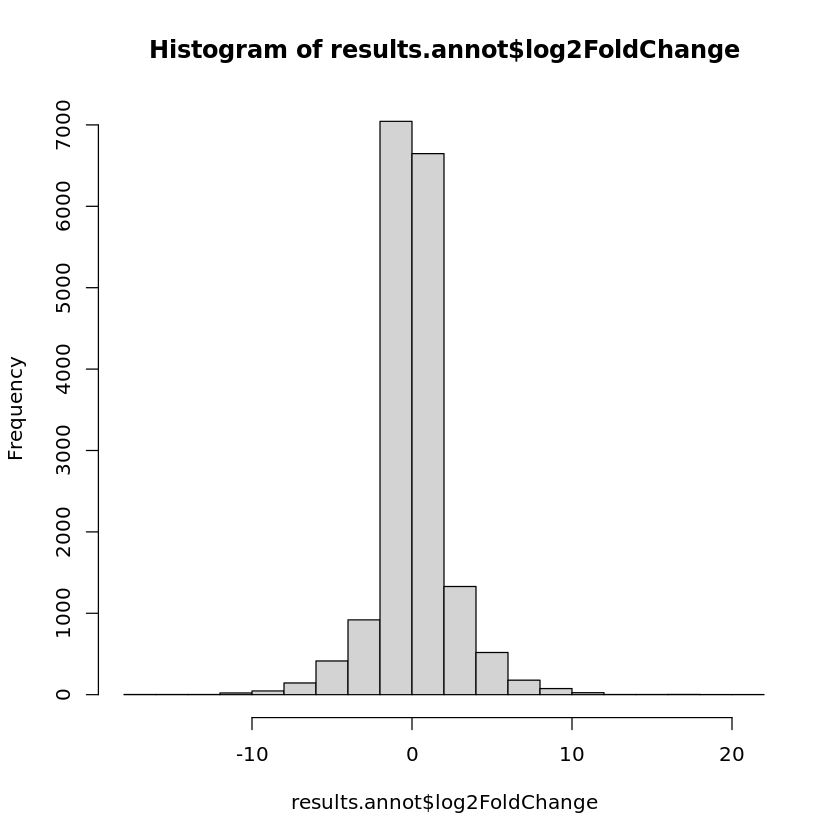

In [21]:
hist(results.annot$log2FoldChange)

#### Plot MA with genes passing the low count filter
The MA plot shows the relationship between the expression change (M) and average expression strength (A); genes with adjusted p-values <0.05 are marked in red.

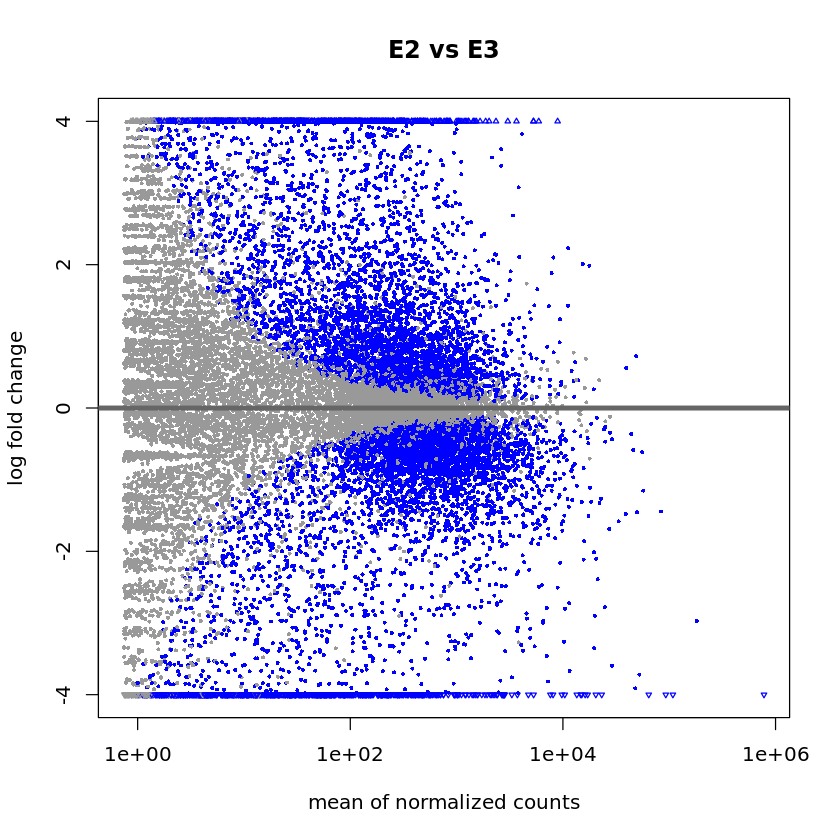

In [22]:
plotMA(DGE.results.clean , alpha = 0.05,  main = "E2 vs E3", ylim = c(-4,4))

#### Identify  DE genes  with  the  desired  adjusted p-value cut-off to plot heatmap and PCA

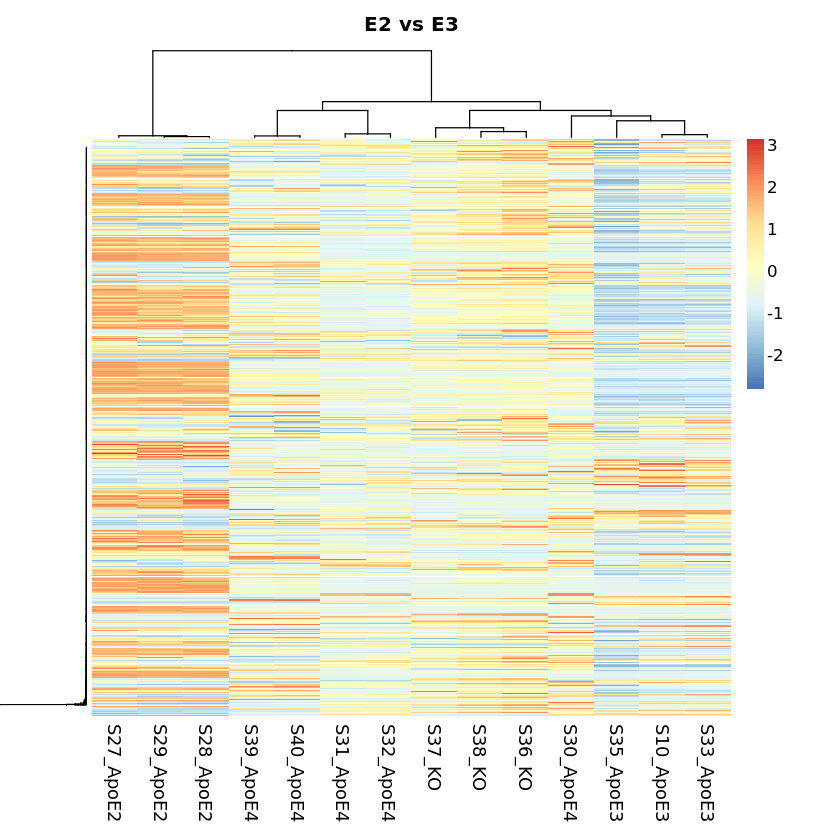

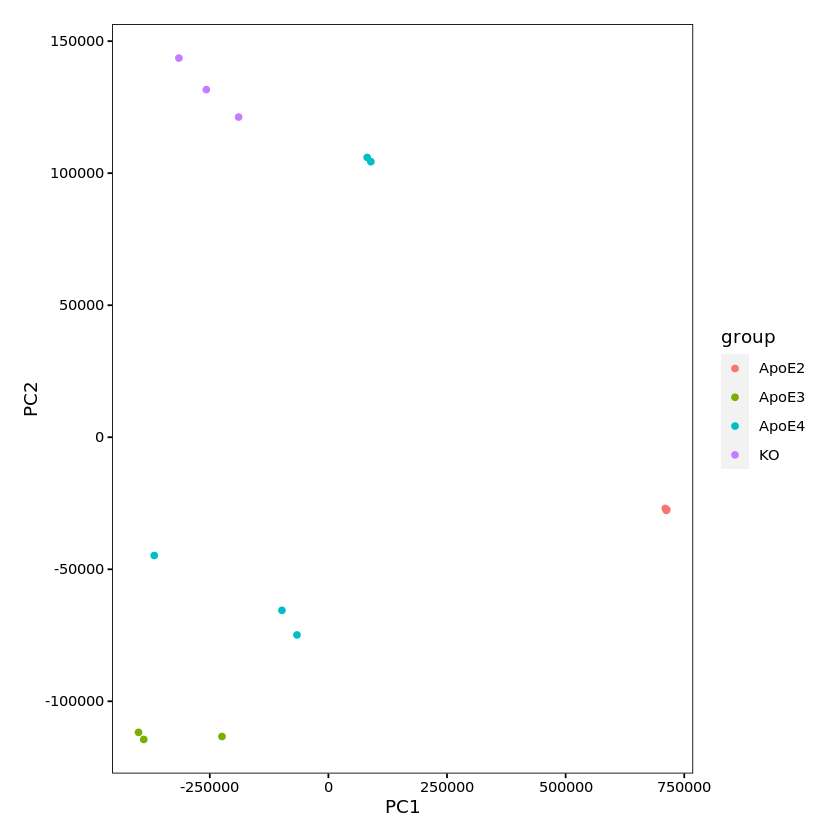

In [23]:
DGEgenes  <- rownames(subset(DGE.results.clean , padj < 0.05))
if(length(DGEgenes)==0){
    DGEgenes=rownames(DGE.results.clean[1:50 ,])
    cat("There are no genes with adj pvalue above 0.05. Showing the top 50 in the heatmap")
}
heatmapset=assay(DESeq)[DGEgenes,]  
labcol=paste(colnames(heatmapset),colData(DESeq)$ApoE_group,sep="_")
aheatmap_function(heatmapset,title = "E2 vs E3",labcol) # one-line function ? does not make much sense
pca_function(heatmapset,colData(DESeq),"ApoE_group")

**This concludes the RNASeq Analysis**

======= Session Info ========

In [24]:
sessionInfo()

R version 4.0.4 (2021-02-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.7.1
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.7.1

locale:
[1] C

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] gridExtra_2.3               ggplot2_3.3.3              
 [3] RColorBrewer_1.1-2          NMF_0.23.0                 
 [5] cluster_2.1.1               rngtools_1.5               
 [7] pkgmaker_0.32.2             registry_0.5-1             
 [9] biomaRt_2.46.3              DESeq2_1.30.1              
[11] SummarizedExperiment_1.20.0 Biobase_2.50.0             
[13] MatrixGenerics_1.2.1        matrixStats_0.58.0         
[15] GenomicRanges_1.42.0        GenomeInfoDb_1.26.2        
[17] IRanges_2.24.1              S4Vectors_0.28.1           
[19] BiocGenerics_0.36.0       